In [1]:
%matplotlib inline
import quimb as qu
import quimb.tensor as qtn
from quimb.tensor.optimize_tensorflow import TNOptimizer

# create a session to explicitly not use eager-mode
import tensorflow as tf
sess = tf.InteractiveSession()

First, find a (dense) PBC groundstate, $| gs \rangle$:

In [2]:
L = 16
H = qu.ham_heis(L, sparse=True, cyclic=True)
gs = qu.groundstate(H)

Then we convert it to a dense 1D 'tensor network':

In [3]:
# this converts the dense vector to an effective 1D tensor network (with only one tensor)
target = qtn.Dense1D(gs)
print(target)

Dense1D([
    Tensor(shape=(2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2), inds=('k0', 'k1', 'k2', 'k3', 'k4', 'k5', 'k6', 'k7', 'k8', 'k9', 'k10', 'k11', 'k12', 'k13', 'k14', 'k15'), tags={'I7', 'I1', 'I11', 'I8', 'I0', 'I14', 'I9', 'I6', 'I12', 'I5', 'I15', 'I4', 'I3', 'I13', 'I10', 'I2'}),
], structure='I{}', nsites=16)


Next we create an initial guess random MPS, $|\psi\rangle$:

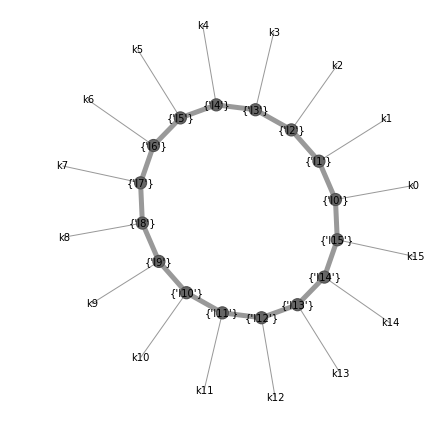

In [4]:
bond_dim = 32
mps = qtn.MPS_rand_state(L, bond_dim, cyclic=True)
mps.graph()

We now need to set-up the function that 'prepares' our tensor network. 
In the current example this involves making sure the state is always normalized.

In [5]:
def normalize_state(psi):
    return psi / (psi.H @ psi) ** 0.5

Then we need to set-up our 'loss' function, the function that returns 
the scalar quantity we want to minimize.

In [6]:
def negative_overlap(psi, target):
    return - (psi.H @ target) ** 2  # minus so as to minimize

In [7]:
optmzr = TNOptimizer(
    mps,  # our initial input, the tensors of which to optimize
    loss_fn=negative_overlap,
    norm_fn=normalize_state,
    loss_constants={'target': target},  # this is a constant TN to supply to loss_fn
)

Now we are ready to optimize our tensor network! Note how we supplied the constant tensor network ``target`` - its tensors will not be changed.

In [8]:
mps_opt = optmzr.optimize(100)  # perform 100 gradient descent steps

-0.9963936206854458: 100%|██████████| 100/100 [00:10<00:00, 10.56it/s]


The output optimized (and normalize) tensor netwwork has already been converted back to numpy:

In [9]:
type(mps_opt[0].data)

numpy.ndarray

And we can explicitly check the returned state indeed matches the loss shown above:

In [10]:
((mps_opt.H & target) ^ all) ** 2

0.9964696823881

Other things to think about might be:

- playing with the optimizer type (here ADAM) and settings (e.g. learning rate). ``'scipy'`` is another good choice which defaults to the L-BFGS-B algorithm.
- using single precision data for better GPU acceleration
- try torch instead using ``from quimb.tensor.optimize_pytorch import TNOptimizer``, though you won't be able to optimize non-real tensor networks